In [ ]:
!pip install transformers graphviz neo4j kuzu langchain > /dev/null

#modules and libraries to be downloaded
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import IPython
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from neo4j import GraphDatabase
from graphviz import Digraph
from IPython.display import Image
import plotly.graph_objects as go

In [ ]:
#Load of REBEL model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
test_text=input("Enter any text you want to generate text based KG on: ")

Enter any text you want to generate text based KG on: Metaflow is an open-source ML platform designed to help data scientists train and deploy ML models. Metaflow primarily serves two functions:  a workflow orchestrator. Metaflow breaks down a workflow into steps. Turning a Python function into a Metaflow step is as simple as adding a @step decorator above the function. Metaflow doesn’t necessarily have all of the bells and whistles that a workflow tool like Airflow can give you, but it is simple, Pythonic, and can be setup to use AWS Step Functions as an external orchestrator. In addition, there is nothing wrong with using proper orchestrators like Airflow or Prefect in conjunction with Metaflow. an infrastructure abstraction tool. This is where Metaflow really shines. Normally a data scientist would have to manually set up the infrastructure required to send model training jobs from their laptop to AWS. This would potentially require knowledge of infrastructure such as API gateways, 

In [ ]:
#token generation using the REBEL model
def token_gen():

    model_inputs = tokenizer(test_text,
                            max_length=512,
                            padding=True,
                            truncation=True,
                            return_tensors='pt')
    gen_kwargs = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 5,
        "num_return_sequences": 4
    }
    generated_tokens = model.generate(
        **model_inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                            skip_special_tokens=False)
    return decoded_preds


In [ ]:
#extraction of triplets from model output so as to appear in head-relation-tail format
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [ ]:
#Defining class for processing entire text
class KG():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

    def save_csv(self,file_name):
        print(f"Saving to file {file_name}")
        reln_df = pd.DataFrame(self.relations)
        reln_df.to_csv(file_name,index=False)


In [ ]:
#entire input text is tokenised here and processed at once
def from_small_text_to_KG(text,verbose=False):
    kg_instance=KG()

    dec_preds=token_gen()
    for sentence_pred in dec_preds:
        relations = extract_relations_from_model_output(sentence_pred)
        for r in relations:
            kg_instance.add_relation(r)

    return kg_instance

In [ ]:
def from_large_text_to_KG(text, span_length=50, verbose=False):
    kg_instance=KG()
    inputs = tokenizer([text], return_tensors="pt")

    #compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    #transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kg_instance.add_relation(relation)
        i += 1

    return kg_instance

In [ ]:
if len(test_text)<=100:
    smallKG=from_small_text_to_KG(test_text)
    relation_df=pd.DataFrame(smallKG.relations)
else:
    largeKG=from_large_text_to_KG(test_text)
    relation_df=pd.DataFrame(largeKG.relations)
relation_df

,head,type,tail,meta
0,Metaflow,use,ML,"{'spans': [[0, 50]]}"
1,Metaflow,programming language,Python,"{'spans': [[0, 50], [45, 95]]}"
2,@step,instance of,decorator,"{'spans': [[45, 95]]}"
3,@step,programming language,Python,"{'spans': [[45, 95]]}"
4,Airflow,programming language,Pythonic,"{'spans': [[90, 140]]}"
5,AWS Step Functions,programming language,Pythonic,"{'spans': [[90, 140]]}"
6,Prefect,programming language,Pythonic,"{'spans': [[90, 140]]}"
7,Metaflow,use,infrastructure abstraction,"{'spans': [[135, 185]]}"
8,Metaflow,use,infrastructure abstraction tool,"{'spans': [[135, 185]]}"
9,Kubernetes,based on,Docker,"{'spans': [[180, 230]]}"


In [ ]:
def NetworkX_KG():

    # Create a regular DiGraph instead of MultiDiGraph
    G = nx.DiGraph()

    # Add nodes and edges from DataFrame, separating head-to-tail and tail-to-head relations
    for _, row in relation_df.iterrows():
        head = row['head']
        tail = row['tail']
        relation_type = row['type']

        if G.has_edge(head, tail):
            G[head][tail]['head_to_tail'].append(relation_type)
        elif G.has_edge(tail, head):
            if 'tail_to_head' not in G[tail][head]:
                G[tail][head]['tail_to_head'] = [relation_type]
            else:
                G[tail][head]['tail_to_head'].append(relation_type)
        else:
            G.add_edge(head, tail, head_to_tail=[relation_type])

    # Plot the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=3000, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # Draw edges with appropriate arrow style
    for (u, v, data) in G.edges(data=True):
        if 'tail_to_head' in data:
            # Bidirectional edge
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                edge_color='black',
                                arrowstyle='<->',
                                arrowsize=20)
        else:
            # Unidirectional edge
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                edge_color='black',
                                arrowstyle='->',
                                arrowsize=20)

    # Prepare edge labels
    edge_labels = {}
    for (u, v, data) in G.edges(data=True):
        label = ""
        if 'head_to_tail' in data:
            label += "→\n" + "\n".join(data['head_to_tail'])
        if 'tail_to_head' in data:
            if label:
                label += "\n\n"
            label += "←\n" + "\n".join(data['tail_to_head'])
        edge_labels[(u, v)] = label

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red',
                                font_size=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title('Knowledge Graph of Relations', fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def Graphviz_KG():
    dot=Digraph()

    for index, row in relation_df.iterrows():
        dot.node(row['head'])
        dot.node(row['tail'])
        dot.edge(row['head'], row['tail'], label=row['type'])

    # Render and display the graph in the notebook
    dot.render('knowledge_graph', format='png', view=True)
    display(Image('knowledge_graph.png'))

In [ ]:
def create_graph(tx, head, relation, tail):
    tx.run("MERGE (a:Node {name: $head}) "
           "MERGE (b:Node {name: $tail}) "
           "MERGE (a)-[r:RELATION {type: $relation}]->(b)",
           head=head, tail=tail, relation=relation)

In [ ]:
def Neo4j_KG():
    uri = "neo4j+s://05e462a4.databases.neo4j.io"  # Replace with your Neo4j instance URI
    username = "neo4j"
    password = "dZXOoPSwOdVdVTRtlqQCn0jnHz88qgFkpAHaI5LcKLY"  # Replace with your Neo4j password
    driver = GraphDatabase.driver(uri, auth=(username,password))


# Write the data to Neo4j
    with driver.session() as session:
        for index, row in relation_df.iterrows():
            session.write_transaction(create_graph, row['head'], row['type'], row['tail'])

    # Close the connection
    driver.close()

In [ ]:
def Plotly_KG():
    G = nx.from_pandas_edgelist(relation_df, source='head', target='tail', edge_attr=True, create_using=nx.DiGraph())


    pos = nx.spring_layout(G)

    # Extract edge labels
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='#888'),
        hoverinfo='none',
        mode='lines')

    config = {
        'scrollZoom': True,       # Enable scroll to zoom
        'modeBarButtonsToRemove': [ 'select2d', 'lasso2d',
                                    'autoScale2d',
                                'resetScale2d', 'hoverClosestCartesian',
                                'hoverCompareCartesian', 'toggleSpikelines'],
        'displaylogo': True      # Hide the Plotly logo
    }


    # Extract node labels
    node_x = []
    node_y = []
    for node in pos:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[node for node in G.nodes()],
        textposition="bottom center",
        hoverinfo='text',
        marker=dict(
            showscale=False,
            colorscale='YlGnBu',
            size=30,
            line_width=1
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network graph made with Plotly',
                    titlefont_size=32,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Python code:  link",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False,showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False,showticklabels=False))
                    )

    fig.update_layout(
        dragmode='zoom',  # Set default dragmode to zoom
        modebar_add=['zoomIn2d', 'zoomOut2d', 'zoom2d','zoomIn2d', 'zoomOut2d']
    )

    fig.show(config=config)

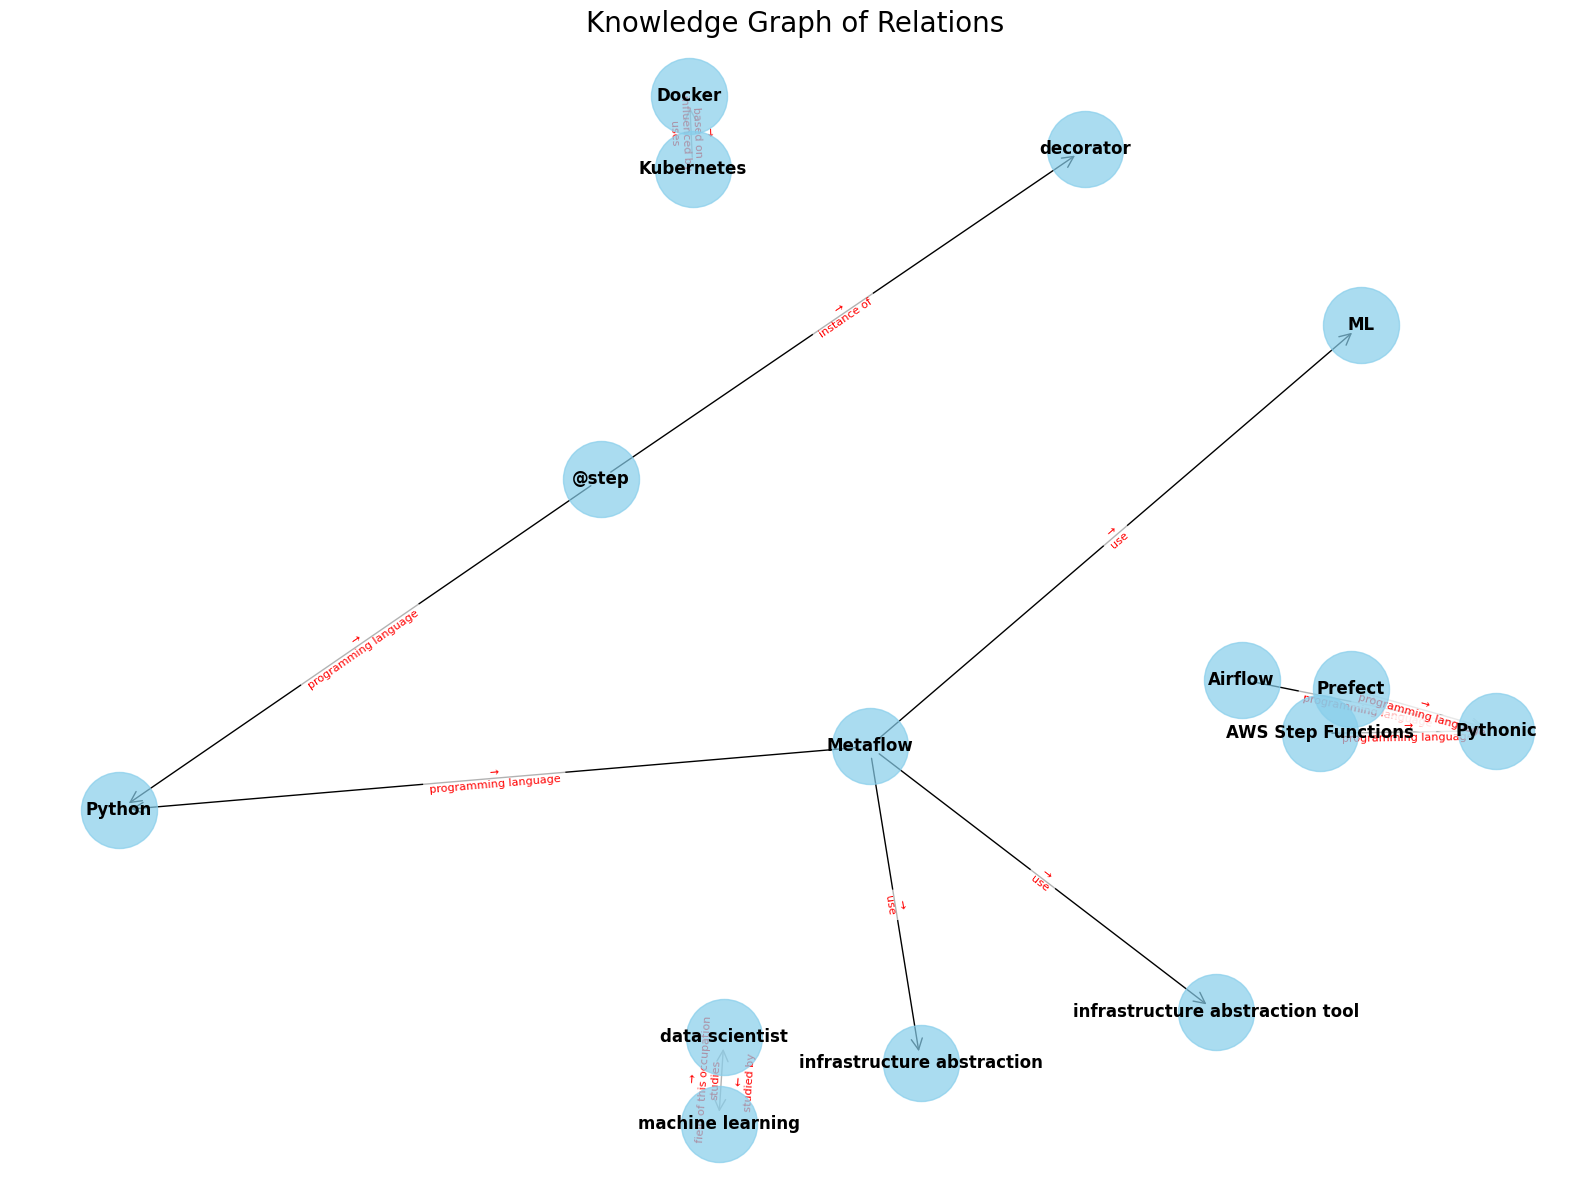

In [ ]:
NetworkX_KG()

In [ ]:
Plotly_KG()

In [ ]:
Neo4j_KG()

<ipython-input-32-dfaaf328787c>:11: DeprecationWarning:

write_transaction has been renamed to execute_write



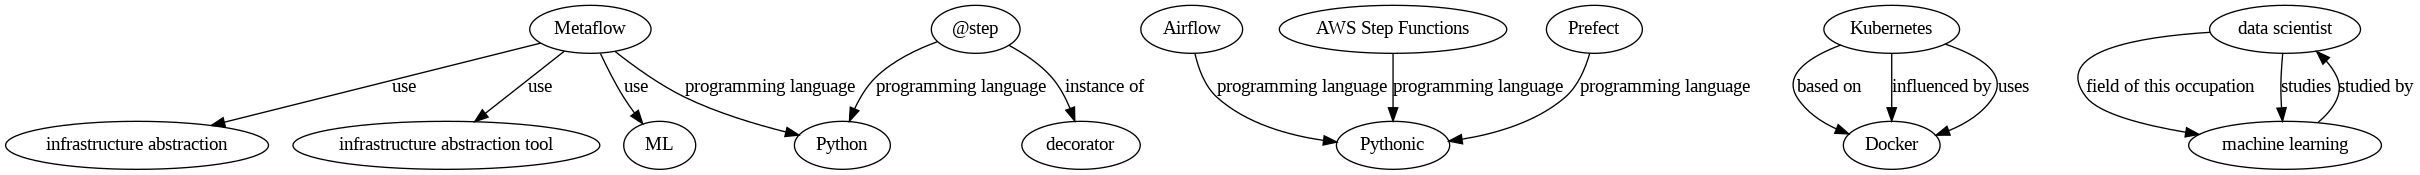

In [ ]:
Graphviz_KG()